Урок 5. Рекуррентные нейронные сети
---

**Домашнее задание**:
Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [147]:
data_path = '../../data/prod_data/prod_data.xlsx'
df = pd.read_excel(data_path, sheet_name='prod')

In [148]:
df

,Date,Well,Formation,Lift type,"Choke, mm","THP, MPa","Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t",...,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"Oil production (plan) daily, t/d","Oil production (plan), t",Workover,Field,Longitude,Latitude
0,1996-05-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,1549.516908,1283.0,0.000000e+00,0.000,...,0.828,1.164,336.0,408.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
1,1996-06-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,4330.917874,3586.0,0.000000e+00,0.000,...,0.828,1.164,696.0,24.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
2,1996-07-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5179.951691,4289.0,0.000000e+00,0.000,...,0.828,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
3,1996-08-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5056.763285,4187.0,0.000000e+00,0.000,...,0.828,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
4,1996-09-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5208.937198,4313.0,0.000000e+00,0.000,...,0.828,1.164,720.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6224,NaT,NaN,NaN,NaN,NaN,NaN,NaN,10648339.0,2.898988e+06,3332110.564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6225,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6226,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
df.shape

(6228, 22)

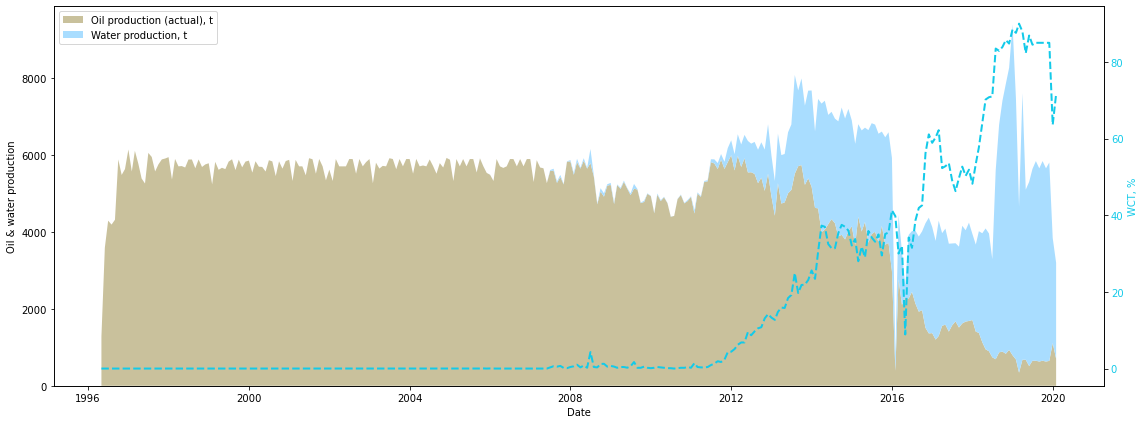

In [150]:
# define well name
well_name = 'Plat-2'

# Data
x = df['Date'].where(df['Well'] == well_name)
y = df['Oil production (actual), t'].where(df['Well'] == well_name).to_numpy(), \
    df['Water production, t'].where(df['Well'] == well_name).to_numpy()
wct = df['WCT, %'].where(df['Well'] == well_name).to_numpy()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil & water production', color='black')
#ax1.plot(x, y, color=color)
colors = ['#C9C19C', '#A9DDFF']
ax1.stackplot(x, y, labels=['Oil production (actual), t', 'Water production, t'], colors=colors)
ax1.tick_params(axis='y', labelcolor='black')
#plt.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#13CAE9'
ax2.set_ylabel('WCT, %', color=color)  # we already handled the x-label with ax1
ax2.plot(x, wct, color=color, linestyle='dashed', linewidth=2,  label='WCT, %')
ax2.tick_params(axis='y', labelcolor=color)

# legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')

#plt.legend(loc='upper left')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

In [151]:
len(x)

6228

In [152]:
df.columns

Index(['Date', 'Well', 'Formation', 'Lift type', 'Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'WCT, %', 'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours', 'Oil production (plan) daily, t/d',
       'Oil production (plan), t', 'Workover', 'Field', 'Longitude',
       'Latitude'],
      dtype='object')

In [153]:
# список признаков, по которым будем учить
features = ['Date', 'Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours', 'Longitude', 'Latitude']

target = 'WCT, %'

In [154]:
df['liquid, m3'] = df['Oil production, m3'] + df['Water production, m3']
df

,Date,Well,Formation,Lift type,"Choke, mm","THP, MPa","Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t",...,"Water density, t/m3",Working hours,Downtime hours,"Oil production (plan) daily, t/d","Oil production (plan), t",Workover,Field,Longitude,Latitude,"liquid, m3"
0,1996-05-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,1549.516908,1283.0,0.000000e+00,0.000,...,1.164,336.0,408.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,1549.516908
1,1996-06-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,4330.917874,3586.0,0.000000e+00,0.000,...,1.164,696.0,24.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,4330.917874
2,1996-07-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5179.951691,4289.0,0.000000e+00,0.000,...,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5179.951691
3,1996-08-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5056.763285,4187.0,0.000000e+00,0.000,...,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5056.763285
4,1996-09-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5208.937198,4313.0,0.000000e+00,0.000,...,1.164,720.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5208.937198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6224,NaT,NaN,NaN,NaN,NaN,NaN,NaN,10648339.0,2.898988e+06,3332110.564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6225,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6226,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
data = df.drop(target, axis=1)
data.head()

,Date,Well,Formation,Lift type,"Choke, mm","THP, MPa","Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t",...,"Water density, t/m3",Working hours,Downtime hours,"Oil production (plan) daily, t/d","Oil production (plan), t",Workover,Field,Longitude,Latitude,"liquid, m3"
0,1996-05-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,1549.516908,1283.0,0.0,0.0,...,1.164,336.0,408.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,1549.516908
1,1996-06-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,4330.917874,3586.0,0.0,0.0,...,1.164,696.0,24.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,4330.917874
2,1996-07-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5179.951691,4289.0,0.0,0.0,...,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5179.951691
3,1996-08-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5056.763285,4187.0,0.0,0.0,...,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5056.763285
4,1996-09-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5208.937198,4313.0,0.0,0.0,...,1.164,720.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989,5208.937198


In [156]:
features, target

(['Date',
  'Choke, mm',
  'THP, MPa',
  'Oil production, m3',
  'Oil production (actual), t',
  'Water production, m3',
  'Water production, t',
  'Gas production, M m3',
  'Working hours',
  'Downtime hours',
  'Longitude',
  'Latitude'],
 'WCT, %')

In [157]:
data.columns

Index(['Date', 'Well', 'Formation', 'Lift type', 'Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours', 'Oil production (plan) daily, t/d',
       'Oil production (plan), t', 'Workover', 'Field', 'Longitude',
       'Latitude', 'liquid, m3'],
      dtype='object')

In [158]:
data.drop(['Date', 'Well', 'Formation', 'Lift type', 'Workover', 'Field'], axis=1, inplace=True)

In [160]:
scaler = StandardScaler()

data = scaler.fit_transform(data)

data

array([[        nan,         nan, -0.28202018, ...,  0.63475143,
         0.99822601, -0.47201144],
       [        nan,         nan,  0.84297692, ...,  0.63475143,
         0.99822601,  0.61462448],
       [        nan,         nan,  1.1863868 , ...,  0.63475143,
         0.99822601,  0.94632446],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [162]:
# список признаков, по которым будем учить
features = ['Choke, mm', 'THP, MPa',
       'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours', 'Longitude', 'Latitude']


In [163]:
# Разбиваем выборку на обучение и на тест.

train_size = 215
val_size = 50
# отступ теста от тренировки
bias = 10

# делим выборку на трейн и тест
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:train_size + bias + val_size][features]

train_data.shape, val_data.shape

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'